# KDF and RF Adversarial Attacks

This notebook seeks to analyze adversarial attacks on KDF. This code relies on attacks provided by [adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox) and investigates black box attacks that have unlimited queries to the model of interest. By definition, these models do not have access to the underlying structure, meaning the results of this notebook may generalize to KDN as well. 

In [ ]:
# Created by: Jacob Desman
# Date: 2022-05-03
# Contact at: jake.m.desman@gmail.com

In [1]:
from kdg.utils import generate_gaussian_parity
from kdg import kdf
import pandas as pd
from joblib import Parallel, delayed

from functions.kdf_adversarial import get_adversarial_examples
from functions.kdf_adversarial import combine_results
from functions.kdf_adversarial import plot_attack
from functions.kdf_adversarial import experiment

## Intuition

To visualize how such attacks work in low dimension, an initial example is shown on the 2D Gaussian XOR Distribution. Intuitively, one would expect points to be moved just beyond the decision thresholds where each of the partitions meet. 

In [2]:
n_classes = 2
n_samples = 1000
n_attack = 10  
x_train, y_train = generate_gaussian_parity(n_samples, cluster_std=0.25)

model = kdf()
model.fit(x_train, y_train)
x_train_adv_kdf, idx, model = get_adversarial_examples(
    model, x_train, n_attack=n_attack, nb_classes=n_classes
)

HopSkipJump: 100%|██████████| 10/10 [06:04<00:00, 36.48s/it]


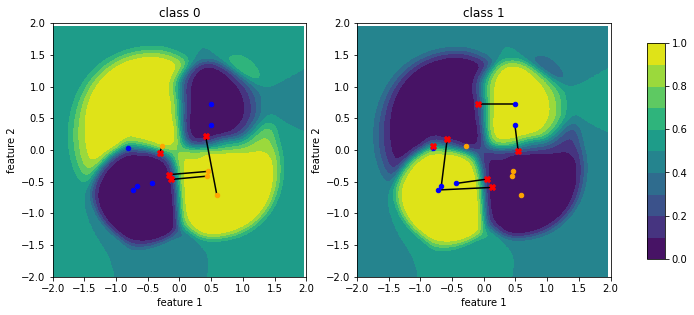

In [3]:
plot_attack(model, x_train[idx], y_train[idx], x_train_adv_kdf, n_classes)

Here, the colored background represents the probability of class $i$ corresponding to the panel title. The orange circles are class $0$ and the blue circles are class $1$. Red crosses are the adversarial samples for class $i$ denoted in the panel title. 

While the Gaussian XOR simulation is not a realistic target for adversarial attacks, it illustrates the intuition of how such attacks work. Adversarial attacks generally seek to perturb points the smallest possible distance beyond the decision threshold. 

## OpenML Experiments

Some blackbox attacks work by using queries to estimate the direction of the gradient to find decision boundaries. One could hypothesize that the well-formed posteriors of KDF make it more difficult to find those boundaries.

This experiment seeks to analyze the classification error and perturbation size of adversarial samples. After training on OpenML datasets, subsets of those datasets which both KDF and RF classify correctly is selected to attack. 50 points are selected due to computational expense. 5 trials of refitting KDF and attacking 50 points are conducted, and averages are reported. OpenML datasets were chosen based on the results in `benchmarks/adversarial/openML_cc18_adversary.py` after running for approximately 12 hours. 

The following cells may take 8-12 hours to run depending on your machine!

In [9]:
dataset_ids = [11, 14, 16, 22, 37, 54, 1063, 1067, 1049]
n_estimators = 500
n_attack = 50
reps = 5
res = Parallel(n_jobs=4)(
    delayed(experiment)(
        dataset_id, 
        n_estimators=n_estimators, 
        n_attack=n_attack, 
        reps=reps
        ) for dataset_id in dataset_ids)

In [10]:
output = combine_results(res)
output

,ID,l2_kdf,l2_rf,linf_kdf,linf_rf,err_adv_kdf,err_adv_rf,delta_adv_err,delta_adv_l2,delta_adv_linf
0,11,1.451298,1.528975,1.186824,1.402729,1.000,1.000,0.000,-0.077676,-0.215905
1,14,0.250159,0.354653,0.095636,0.161158,0.876,1.000,-0.124,-0.104494,-0.065522
2,16,8.041531,9.162051,3.225662,5.173017,0.896,1.000,-0.104,-1.120520,-1.947354
3,22,1.026957,140.362979,0.794027,63.593480,0.864,0.980,-0.116,-139.336022,-62.799453
4,37,3.191146,15.314023,3.012296,12.744888,0.528,0.880,-0.352,-12.122876,-9.732592
5,54,30.474660,20.126855,21.502373,13.627263,0.872,1.000,-0.128,10.347805,7.875110
6,1063,1.599227,17996.708015,1.455934,8416.873057,0.404,0.652,-0.248,-17995.108788,-8415.417124
7,1067,2.251710,19.963257,1.867759,10.262538,0.496,0.504,-0.008,-17.711547,-8.394779
8,1049,0.165537,28.626332,0.142142,15.252067,0.388,0.612,-0.224,-28.460795,-15.109925


There are a few observations:
1. KDF's classification error of the adversarial samples is lower than RF in each case except for one
2. The $l_2$ norm and $l_{\infty}$ of the adversarial samples for KDF are lower in each case except one, supporting the idea that KDF's better calibrated posteriors make it more difficult for the adversarial attacks to perturb the original samples